In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext line_profiler
from tqdm import tqdm_notebook as tqdmn
import pandas as pd
from geopandas import GeoDataFrame
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as tkr
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from geopandas import sjoin
import pickle
import re;pat = re.compile(r'''(-*\d+\.\d+ -*\d+\.\d+);*''');new_geo=[]
import warnings
import seaborn as sns
import sys

warnings.filterwarnings("ignore")
sys.path.append('/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/')
from IPython.display import clear_output
save=False
load=False
print("Save bool set to %s and Load %s"%(str(save),str(load)))

Save bool set to False and Load False


In [4]:
from helpers_locs_to_home import time_2_date

###################################################################################
#####################                RAW DATA             #########################
###################################################################################

# Geolocations
dgeo=pd.read_csv(header=None,sep="\t",
                 filepath_or_buffer="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/2016-2018_locs.txt")
dgeo.columns=["usr","time","lat","lon","text"]
fechas,days,hours,minutes,seconds,years,months=time_2_date(dgeo.time)
dgeo['day']=days;dgeo['hour']=hours;dgeo['min']=minutes;dgeo['sec']=seconds
dgeo['year']=years;dgeo['month']=months;dgeo['fecha']=fechas
#dgeo=dgeo.drop(labels="time",axis=1)

# Profiles
data_prof_18=pd.read_csv(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/icdm18/issues/icdm_geousers_profile_18.txt",
    sep="\t",
    header=-1,
    names=["id","time","lat","lon","geo_pt","service","profile","follows","friends",
           "nb urls","loc_name","geo_type"],
    index_col=False)

# Users in France
france=Polygon([[-4.9658203125,42.3585439175],[8.4375,42.3585439175],
                [8.4375,51.2344073516],[-4.9658203125,51.2344073516],
                [-4.9658203125,42.3585439175]])
locs=[Point((lon,lat)) for lon,lat in zip(dgeo.lon,dgeo.lat)]
dgeo_france=dgeo[[france.contains(geo_pt) for geo_pt in locs]]

locs_prof=[Point((float(lon),float(lat))) 
           for lon,lat in zip(data_prof_18.lon,data_prof_18.lat)]

dgeo_prof_france_18=data_prof_18[[france.contains(geo_pt) 
                                  for geo_pt in locs_prof]]

print("Number of geolocated tweets during 2016-2018... %d geolocations"%
      dgeo_france.shape[0])
print("Number of geolocated tweets during 2016-2018 in France... %d geolocations"%
      dgeo_prof_france_18.shape[0])

# Text of geolocated users
usr_tweet_text=pd.read_csv(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/tweets/all_geolocated_users.csv",
    sep=';',header=0,
)

###################################################################################
#####################                SYNTHETIC DATA             ###################
###################################################################################

# Fake Locations
from collections import Counter
dec_prec=5
nb_rep_thresh=10
pre_fake_locs=pd.read_csv("/warehouse/COMPLEXNET/jlevyabi/geoloc/txt_files/fake_locs.txt",
                          names=["pre"])
fake_locs=[]
for x in pre_fake_locs.pre:
    try:
        lat,lon=float(x.split("-")[0]),float(x.split("-")[-1])
    except:
        continue
    if len(x)==3:
        fake_locs.append(str((lat,-lon)))
    else:
        fake_locs.append(str((lat,lon)))

fake_locs=list(set(fake_locs))
pre_fake=Counter([(round(x[0],dec_prec),round(x[1],dec_prec))
                  for x in  data_prof_18[["lat","lon"]].values])
set_toher_fakes=set([x for x in pre_fake if pre_fake[x]>nb_rep_thresh])

dic_iris_not_nan=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic_iris.p","rb"))
dic_final_not_nan=pickle.load(
        open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic.p","rb"))

100%|██████████| 536291/536291 [00:08<00:00, 60338.83it/s]


Number of geolocated tweets during 2016-2018... 428370 geolocations
Number of geolocated tweets during 2016-2018 in France... 488510 geolocations


In [6]:
from tqdm import tqdm
# Combine Datasets
all_info_df=pd.merge(dgeo_france,dgeo_prof_france_18,how="inner",
                  left_on=["usr","lat","lon","time"],
                  right_on=["id","lat","lon","time"]).drop(["id","loc_name","geo_type"],axis=1)
all_info_dic={}
for it,row in tqdm(all_info_df.iterrows()):
    all_info_dic.setdefault(row.usr,[])
    all_info_dic[row.usr].append(all_info_df.iloc[it])
for usr,val in tqdmn(all_info_dic.items()):
    all_info_dic[usr]=pd.DataFrame(val,columns=list(all_info_df.columns))

432052it [06:23, 1126.68it/s]


HBox(children=(IntProgress(value=0, max=50268), HTML(value='')))

In [61]:
import random as rd
ix=rd.sample(range(len(all_info_dic)),1)[0]
list(all_info_dic.values())[ix][["usr","time","lat","lon","text","profile","service"]]

,usr,time,lat,lon,text,profile,service
264018,268874615,2017-04-27T20:18:53.000Z,45.753540,4.932280,Dancing squad lors du stage Glee à l'#EFACM. 👯...,it takes time learning to fly,Instagram
340320,268874615,2017-10-02T19:20:13.000Z,43.424722,6.767778,"— say you won't let go. 🐱♡ à Saint-Raphaël, Va...",it takes time learning to fly ❥ i'm probably p...,Instagram
352426,268874615,2017-10-13T22:03:17.000Z,45.733560,4.817450,Première expérience de la réalité virtuelle. B...,it takes time learning to fly ❥ i'm probably p...,Instagram
428120,268874615,2018-01-24T20:39:11.000Z,44.583300,-0.083333,Le sentiment d'exister ne devrait jamais deven...,it takes time learning to fly ❥,Instagram


In [68]:
###################### #############################################################
#####################                IRIS DATA             ########################
###################################################################################

from IPython.display import clear_output
home_most_freq_all_iris=go_through_home_candidates(dic_iris_not_nan,take_most_frequent)
home_most_freq_night_iris=go_through_home_candidates(dic_iris_not_nan,take_most_frequent_night)
clear_output()

dic_all_users={usr:{"profile":list(set(all_info_dic[int(usr)].profile)),
                    "locations":all_info_dic[int(usr)][["lat","lon","text",
                                                   "day", "hour","min","sec",
                                                   "year","month","fecha",
                                                   "geo_pt","service"]],
                    "inferred_loc":home_most_freq_all_iris[str(usr)][["lat","lon"]],
                    "suppl_info":home_most_freq_all_iris[str(usr)]} 
               for usr in tqdmn(home_most_freq_all_iris.keys()) 
               if str(usr) in home_most_freq_all_iris and int(usr)  in all_info_dic}

dic_all_users_inf_no_fake={k:v for k,v in  dic_all_users.items()
                           if not((round(v["inferred_loc"]["lat"],dec_prec),
                                   round(v["inferred_loc"]["lon"],dec_prec))
                                  in set_toher_fakes) }

dic_all_users_all_no_fake={k:v for k,v in  dic_all_users.items()
                           if np.all(
                               [len(set([(round(lat,dec_prec),round(lon,dec_prec))
                                         for lat,lon in v["locations"][["lat","lon"]].values])
                                    .intersection(set_toher_fakes))==0]
                           )
                          }

ineq_thresh=6
dic_all_users_all_no_fake_ses_clear={k:v for k,v in  dic_all_users_all_no_fake.items()
                                     if (type(v["suppl_info"]["DEC_RD13"]) is float and 
                                         v["suppl_info"]["DEC_RD13"]<ineq_thresh)}

HBox(children=(IntProgress(value=0, max=13504), HTML(value='')))

In [70]:
print("Number of different locations ... %d"%len(pre_fake))
print("Number of repeated (=fake) locations ... %d"%len(set_toher_fakes))
print("Number of geolocated users ... %d"%len(dic_all_users))
print("Number of users not geolocated to fake locations... %d"%len(dic_all_users_inf_no_fake))
print("Number of users not having used fake locations... %d"%len(dic_all_users_all_no_fake))
print("Number of users not having used fake locations and reliable ses estimation... %d"
      %len(dic_all_users_all_no_fake_ses_clear))


Number of different locations ... 186207
Number of repeated (=fake) locations ... 5113
Number of geolocated users ... 1653
Number of users not geolocated to fake locations... 1651
Number of users not having used fake locations... 610
Number of users not having used fake locations and reliable ses estimation... 255


In [72]:
###################################################################################
#####################                INSEE DATA             #######################
###################################################################################

from IPython.display import clear_output
home_most_freq_all=go_through_home_candidates(dic_final_not_nan,take_most_frequent)
home_most_freq_night=go_through_home_candidates(dic_final_not_nan,take_most_frequent_night)
clear_output()

dic_all_users_insee={usr:{"profile":list(set(all_info_dic[int(usr)].profile)),
                    "locations":all_info_dic[int(usr)][["lat","lon","text",
                                                   "day", "hour","min","sec",
                                                   "year","month","fecha",
                                                   "geo_pt","service"]],
                    "inferred_loc":home_most_freq_all[str(usr)][["lat","lon"]],
                    "suppl_info":home_most_freq_all[str(usr)]} 
               for usr in tqdmn(home_most_freq_all.keys()) 
               if str(usr) in home_most_freq_all and int(usr)  in all_info_dic}

dic_all_users_inf_no_fake_insee={k:v for k,v in  dic_all_users_insee.items()
                           if not((round(v["inferred_loc"]["lat"],dec_prec),
                                   round(v["inferred_loc"]["lon"],dec_prec))
                                  in set_toher_fakes) }

dic_all_users_all_no_fake_insee={k:v for k,v in  dic_all_users_insee.items()
                           if np.all(
                               [len(set([(round(lat,dec_prec),round(lon,dec_prec))
                                         for lat,lon in v["locations"][["lat","lon"]].values])
                                    .intersection(set_toher_fakes))==0]
                           )
                          }

HBox(children=(IntProgress(value=0, max=20389), HTML(value='')))

In [73]:
print("Number of different locations ... %d"%len(pre_fake))
print("Number of repeated (=fake) locations ... %d"%len(set_toher_fakes))
print("Number of geolocated users ... %d"%len(dic_all_users_insee))
print("Number of users not geolocated to fake locations... %d"%len(dic_all_users_inf_no_fake_insee))
print("Number of users not having used fake locations... %d"%len(dic_all_users_all_no_fake_insee))


Number of different locations ... 186207
Number of repeated (=fake) locations ... 5113
Number of geolocated users ... 2542
Number of users not geolocated to fake locations... 2538
Number of users not having used fake locations... 988


In [91]:
from bs4 import BeautifulSoup as bs
import folium
import random as rd
from PIL import Image
import urllib.request
#import wget
datadir="/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/images_suspected_locs/"
def get_map(x,y,z,size, filename) :
    static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)
    static_map_filename, headers = urllib.request.urlretrieve(static_map, filename)
    return static_map_filename

def geomap(df,inf_loc,sup_info,income_name,zoom=10, point_size=10, point_color='r', point_alpha=1):
    #corrections to match geo with static map
    has_used_bad=False
    y = np.mean(df['lat'])
    x = np.mean(df['lon'] )
    map_osm = folium.Map(location=[y,x])
    coors=["red","blue","yellow"] 
    #INSEE
    coords=[(y,x) for x,y in sup_info.geometry_poly.values[-1].exterior.coords]
    #IRIS:
    #coords=[(y,x) for x,y in sup_info.geometry_poly.exterior.coords]
    folium.PolyLine(coords,
                                color="red",
                                popup="%d € "%int(sup_info[income_name])).add_to(map_osm)
    folium.CircleMarker([inf_loc.lat,inf_loc.lon],
                        radius=100,fill=True,color="black").add_to(map_osm)
    text_to_append=[("""
                    %s/%s/%s - %sh <br>
                    %.4f,%.4f<br>
                    {0}
                    """%(x,y,z,t,lat,lon)).format(text)
                    for x,y,z,t,text,lat,lon in zip( df.fecha,df.month,
                                                    df.year,df.hour,df.text,df.lat,df.lon)]
    for lng, lat, desc in zip(df.lon.values,df.lat.values, text_to_append):
        popup=folium.Popup(desc,parse_html=True)
        if not (((round(lat,5),round(lng,5))) in set_toher_fakes):
            folium.CircleMarker([lat, lng], radius=10,fill=True,
                                color='#3186cc',fill_color='#3186cc',
                                 popup=popup,parse_html=True).add_to(map_osm)
        else:
            folium.CircleMarker([lat, lng], radius=10,fill=True, 
                                color='#d66426',fill_color='#d66426',
                                 popup=popup,parse_html=True).add_to(map_osm)
            has_used_bad=True
    return map_osm,has_used_bad

dic_used=dic_all_users_all_no_fake_insee
idx=rd.sample(range(len(dic_used)),1)[0]
df_merged=list(dic_used.values())[idx]["locations"]
inferred=list(dic_used.values())[idx]["inferred_loc"]
si=(list(dic_used.values())[idx]["suppl_info"])
x,y=geomap(df_merged,inferred,si,"income")
print(idx,list(dic_used.keys())[idx],y)
#plt.show()

369 583894936 False


In [92]:
x

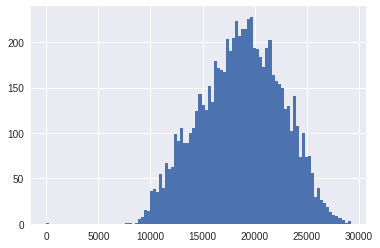

In [395]:
plt.hist([int(v["suppl_info"]["income"]) for v in dic_used.values()],bins=100);

In [289]:
Counter([int(v["suppl_info"]["income"]>18776) for v in dic_used.values()])

Counter({0: 3700, 1: 3755})

In [250]:
d_ckpt=pickle.load(open("/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/last_insee_drop.p","rb"))
geo_insee_dic=d_ckpt["geo_insee_dic"]
geo_insee=d_ckpt["geo_insee"]
dic_pd_home_condensed=d_ckpt["dic_pd_home_condensed"]
geo_insee_dic_KEYS=list(geo_insee_dic.keys())


Unnamed: 0                                                    0
idINSPIRE                        CRS3035RES200mN2030000E4254200
id                                        LAEA200M_N10150E21271
idk                                   N10150E21267-N10163E21271
ind_c                                                         1
nbcar_x                                                      16
men                                                          20
men_surf                                                   2400
men_occ5                                                     13
men_coll                                                      0
men_5ind                                                      0
men_1ind                                                      8
i_1ind                                                        0
men_prop                                                     15
i_prop                                                        1
men_basr                                

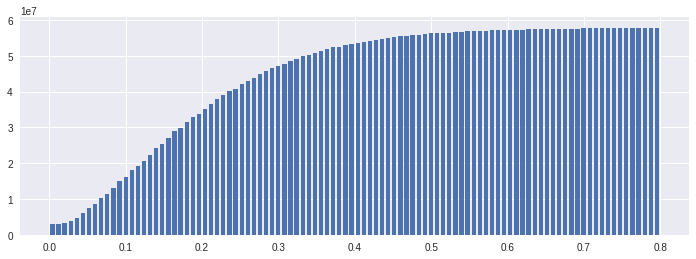

In [272]:
plt.figure(figsize=(12,4))
plt.hist([float(x/(y+0.0)) for x,y in geo_insee[["men_basr","men"]].values if y>0],
         weights=[y for y in geo_insee["men"] if y>0],cumulative=True,
         bins=100,rwidth=0.7,log=False);

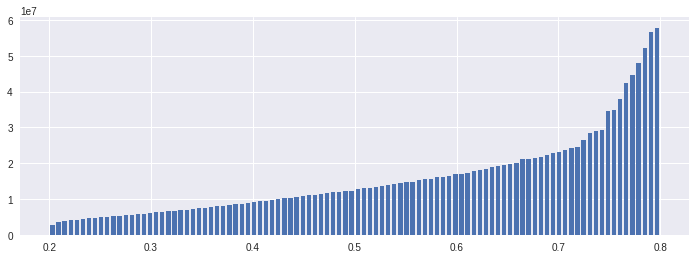

In [273]:
plt.figure(figsize=(12,4))
plt.hist([float(x/(y+0.0)) for x,y in geo_insee[["men_prop","men"]].values if y>0],
         weights=[y for y in geo_insee["men"] if y>0],cumulative=True,
         bins=100,rwidth=0.7,log=False);

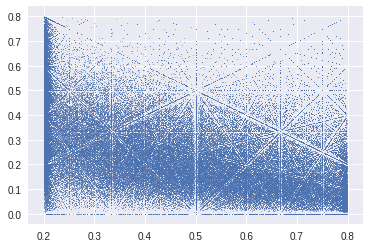

In [280]:
plt.scatter(np.array([x/(y+0.0) for x,y in geo_insee[["men_prop","men"]].values if y>0]),
            np.array([x/(y+0.0) for x,y in geo_insee[["men_basr","men"]].values if y>0]),
            s=0.2,
           )

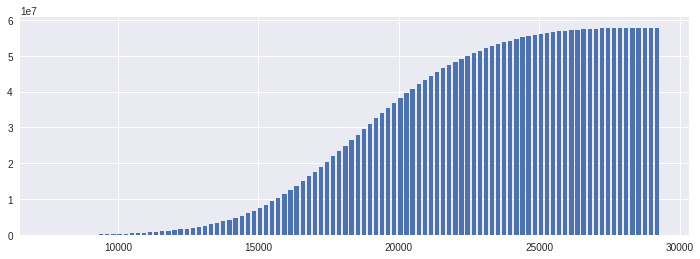

In [276]:
plt.figure(figsize=(12,4))
plt.hist([x for x in geo_insee.income if x>0],
         weights=[x for x,y in geo_insee[["men","income"]].values if y>0],
         bins=100,rwidth=0.7,cumulative=True);

In [288]:
Counter(geo_insee.income.astype(int)).most_common(10)

[(18145, 468),
 (18341, 443),
 (17974, 436),
 (17658, 429),
 (18974, 426),
 (17379, 425),
 (19079, 424),
 (19307, 423),
 (18004, 422),
 (18375, 421)]

In [284]:
np.median([y for x,y in geo_insee[["men","income"]].values 
           if x>0 and y>0
           for i in range(int(x))])

18776.4375

In [282]:
np.median?

In [112]:
from sklearn.cluster import DBSCAN
uid = 4902

#1deg at 40deg latitude is 111034.61 meters
#set radius at 300 mt
eps = 260/111034.61 #The maximum distance between two samples for them to be considered as in the same neighborhood.

data = df_merged[['lat','lon']]
db = DBSCAN(eps=eps, min_samples=3, n_jobs=1).fit(np.array(data[['lat','lon']])) ¡# atleast 3 points in a cluster

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
df_merged['dbscan_cluster'] =  db.labels_
df_merged['dbscan_core']    = core_samples_mask
print("# clusters: {}".format(len(set(df_merged['dbscan_cluster']))))

SyntaxError: invalid character in identifier (<ipython-input-112-b0f3503a2510>, line 9)

In [ ]:
from tqdm import tqdm
show_fakes_14=[it for it,z in tqdm(df14_good_service[["lat","lon"]].iterrows()) if str((z[0],z[1])) in fake_locs]
def to_color(xy):
    if str((xy.lat,xy.lon)) in fake_locs:
        return ["background-color: #d6db57" for i in range(xy.shape[0])]
    else:
        return [""for i in range(xy.shape[0])]

    usrs=list(set(df14_good_service.id))
nb_geotweets_from_same_loc_per_usr=([Counter([str((row.lat,row.lon))
                   for it,row in df14_good_service[df14_good_service.id==usr].iterrows()]).most_common(1)[0][1]
                  for usr in tqdmn(usrs)])

nb_geotweets_per_usr=([len([str((row.lat,row.lon))
                   for it,row in df14_good_service[df14_good_service.id==usr].iterrows()])
                  for usr in tqdmn(usrs)])

ifd=df14_good_service.ix[show_fakes_14].id.sample(1).values[0]
x=df14_good_service[df14_good_service.id==ifd]
x.style.apply(to_color, axis=1)

dic_iris_not_nan=pickle.load(open(
    "/warehouse/COMPLEXNET/jlevyabi/ml_soc_econ/data_files/UKSOC_rep/all_together_dic_iris.p","rb"))


usrs_with_fake_locs=[str(x) for x in df14_good_service.ix[show_fakes_14].id.values]
usrs_with_home_and_fake_locs=list(set(usrs_with_fake_locs).intersection(set(list(dic_iris_not_nan.keys()))))

### Locations to Home 

In [67]:
%pdb off
uk = '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 \
+x_0=400000 +y_0=-100000 +ellps=airy \
+towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs'
from pyproj import transform,Proj
from datetime import datetime
import numpy as np
import pandas as pd

def proj_arr(points,proj_to):
    inproj = Proj(init='epsg:4326')
    outproj = Proj(proj_to)
    func = lambda x: transform(inproj,outproj,x[1],x[0])
    return np.array(list(map(func, points)))

def take_most_frequent(geopandas_usr,min_times=5,min_days=1):
    polys_visited=list(geopandas_usr.idINSPIRE)
    time_of_visit=[datetime(int(row.year),int(row.month),int(row.fecha),
                            int(row.hour),int(row.minu),int(row.sec))
                   for it,row in geopandas_usr.iterrows()]
    locat_mode=Counter(polys_visited).most_common(1)[0][0]
    nb_times=Counter(polys_visited).most_common(1)[0][1]
    inter_idx=np.where([x==locat_mode for x in polys_visited])[0].tolist()
    time_diff=[time_of_visit[i] for i in inter_idx]
    if nb_times>=min_times and (max(time_diff)-min(time_diff)).days>=min_days:
        idx_mode=polys_visited.index(locat_mode)
        return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]
    else:
        return None,None

def get_check_in_rate_margin_most_freq(geopandas_usr):
    polys_visited=list(geopandas_usr.idINSPIRE)
    inter=Counter(polys_visited).most_common(2)
    if len(inter)<2:
        return None,None,None,None,None
    locat_mode,sec_locat_mode=inter
    idx_mode,idx_mode_sec=polys_visited.index(locat_mode[0]),polys_visited.index(sec_locat_mode[0])
    return (idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]],
            idx_mode_sec,geopandas_usr.iloc[idx_mode_sec][["lat","lon"]],
           ((locat_mode[1]+0.0-sec_locat_mode[1])/(sec_locat_mode[1]+locat_mode[1])))

def take_most_frequent_night(geopandas_usr,start=21,stop=6) :
    polys_visited=(geopandas_usr.idINSPIRE)
    polys_visited_night=polys_visited[(geopandas_usr.hour>=start)|(geopandas_usr.hour<stop)]
    if len(polys_visited_night)==0:
        return None,None
    locat_mode=Counter(polys_visited_night).most_common(1)[0][0]
    idx_mode=list(polys_visited).index(locat_mode)
    return idx_mode,geopandas_usr.iloc[idx_mode][["lat","lon"]]

def get_distance_matrix(geopandas_usr):
    x = np.array(geopandas_usr[["lat","lon"]]).astype(float).tolist()
    y=proj_arr(x,uk)
    ztree = cKDTree(y)
    z = ztree.sparse_distance_matrix(ztree,1e6,p=2).todense()
    return z

def distance_to_home(geopandas_usr,select_home_loc,args):
    idx,loc=select_home_loc(geopandas_usr,*args)
    if idx is None:
        return None,None,None
    mat_dist=get_distance_matrix(geopandas_usr)
    return mat_dist[idx,:].tolist()[0],list(geopandas_usr.day),list(geopandas_usr.hour)

def go_through_home_candidates(dic_gpd,select_home_loc):
    dic_exam={}
    for usr,gpd in tqdmn(dic_gpd.items()):
        idx,loc=select_home_loc(gpd)
        if idx is None:
            continue
        dic_exam.setdefault(usr,gpd.iloc[idx])
    return dic_exam

def go_through_geol_users(dic_gpd,select_home_loc,args,outlier_lim=6e4):
    dic_per_day={k:np.zeros(24) for k in range(7)}
    dic_nb_per_day={k:np.zeros(24) for k in range(7)}
    dic_exam={}
    loss=[]
    for usr,gpd in tqdmn(dic_gpd.items()):
        dic_exam.setdefault(usr,[])
        dists,days,hours=distance_to_home(gpd,select_home_loc,args)
        new_dists=np.array(dists)
        if dists is None:
            continue
        loss.append(1-(np.sum([new_dists<outlier_lim])+0.0)/len(dists) )
        dists=new_dists[new_dists<outlier_lim]
        for dist,day,hour in zip(dists,days,hours):
            dic_exam[usr].append(dist)
            dic_per_day[day][hour]+=dist
            dic_nb_per_day[day][hour]+=1
    dic_day={}
    for k,v in dic_per_day.items():
        dic_day[k]=(v/dic_nb_per_day[k])/100
    return dic_day,dic_exam,loss

Automatic pdb calling has been turned OFF
